# Model A: Time-Frequency Domain U-Net for Music Source Separation

This notebook demonstrates music source separation using a U-Net architecture in the time-frequency domain.

## 1. Imports and Environment Setup

- Import required libraries (torch, numpy, matplotlib, etc.)

- Set device (CPU/GPU)

In [26]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import Audio, display

sys.path.append('..')

from models import utils, model_A as ma

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## 2. Data Loading and Preprocessing

- Load example mixture and target data (from .npy files)

- Visualize waveforms and spectrograms

- Normalize or preprocess as needed

In [27]:
%matplotlib inline 

import sys
import numpy as np
import musdb
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append('..') 
from models import utils
from models.utils import AudioProcessor

# ==============================================================================
# 1. PREPARE CURRICULUM CACHE
# ==============================================================================
print("Checking Data Cache...")
mus = musdb.DB(download=True)
utils.prepare_curriculum_cache(mus, cache_dir="../data/curriculum")

# ==============================================================================
# 2. LOAD DATA PATHS FOR BOTH STAGES
# ==============================================================================
data_root = Path("../data/curriculum")
s1_mix_path = data_root / "stage1" / "mixture"
s1_tgt_path = data_root / "stage1" / "target"
s2_mix_path = data_root / "stage2" / "mixture"
s2_tgt_path = data_root / "stage2" / "target"

mix_files_stage1 = sorted(list(s1_mix_path.glob("*.npy")))
tgt_files_stage1 = sorted(list(s1_tgt_path.glob("*.npy")))
mix_files_stage2 = sorted(list(s2_mix_path.glob("*.npy")))
tgt_files_stage2 = sorted(list(s2_tgt_path.glob("*.npy")))

print(f"\n Data Ready!")
print(f"   Stage 1 Samples: {len(mix_files_stage1)}")
print(f"   Stage 2 Samples: {len(mix_files_stage2)}")

Checking Data Cache...
Cache found at ..\data\curriculum. Skipping generation.

 Data Ready!
   Stage 1 Samples: 144
   Stage 2 Samples: 144


## 3. Model Architecture

- Show the U-Net model code

- Print model summary

In [28]:
from models import model_A as ma

# Model summary (default architecture)
model_summary = ma.TimeFrequencyDomainUNet(in_channels=1, out_channels=1, base_filters=64, num_layers=4).to(device)
print(model_summary)
del model_summary

TimeFrequencyDomainUNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (block): Sequential(
        (0): ConvLayer2D(
          (block): Sequential(
            (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvLayer2D(
          (block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (block): Sequential(
        (0): ConvLayer2D(
          (block): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e

## 4. Training Setup

In [29]:
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from models import model_A as ma
from models import utils

# Model hyperparameters
in_channels = 1
out_channels = 1
base_filters = 32
num_layers = 4
batchnorm = True
dropout = 0.0

# Overfit model hyperparameters
overfit_base_filters = 128
overfit_num_layers = 4
overfit_batchnorm = True
overfit_dropout = 0.0
overfit_learning_rate = 3e-4
overfit_num_epochs = 100

# Training hyperparameters
learning_rate = 1e-4
patience = 5
batch_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = utils.AudioProcessor(device=device)

# Instantiate models
model = ma.TimeFrequencyDomainUNet(in_channels=in_channels, out_channels=out_channels, base_filters=base_filters, num_layers=num_layers, batchnorm=batchnorm, dropout=dropout).to(device)
overfit_model = ma.TimeFrequencyDomainUNet(in_channels=in_channels, out_channels=out_channels, base_filters=overfit_base_filters, num_layers=overfit_num_layers, batchnorm=overfit_batchnorm, dropout=overfit_dropout).to(device)

# Optimizers and losses
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
overfit_loss_fn = nn.MSELoss()
overfit_optimizer = optim.Adam(overfit_model.parameters(), lr=overfit_learning_rate)

print(f"Setup Complete:")
print(f"   - Device: {device}")
print(f"   - Model: {model.__class__.__name__} (Filters={base_filters}, Layers={num_layers})")
print(f"   - Overfit Model: {overfit_model.__class__.__name__} (Filters={overfit_base_filters}, Layers={overfit_num_layers})")
print(f"   - Loss Function: {loss_fn.__class__.__name__}")
print(f"   - Optimizer: {optimizer.__class__.__name__} (lr={learning_rate})")
print(f"   - Overfit Optimizer: {overfit_optimizer.__class__.__name__} (lr={overfit_learning_rate})")

Setup Complete:
   - Device: cuda
   - Model: TimeFrequencyDomainUNet (Filters=32, Layers=4)
   - Overfit Model: TimeFrequencyDomainUNet (Filters=128, Layers=4)
   - Loss Function: MSELoss
   - Optimizer: Adam (lr=0.0001)
   - Overfit Optimizer: Adam (lr=0.0003)


## 5. Training Loop

### 5.a Overfit Method

- Train the model on a very small subset (e.g., one batch or a few samples) to ensure it can overfit and the implementation is correct.


Starting Overfit Test...
✓ Found Checkpoint: ../checkpoints/debug_overfit.pth


C:\Users\MARKUS-VIDER\AppData\Local\Temp\ipykernel_7348\2190837469.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(save_path, map_location=device)


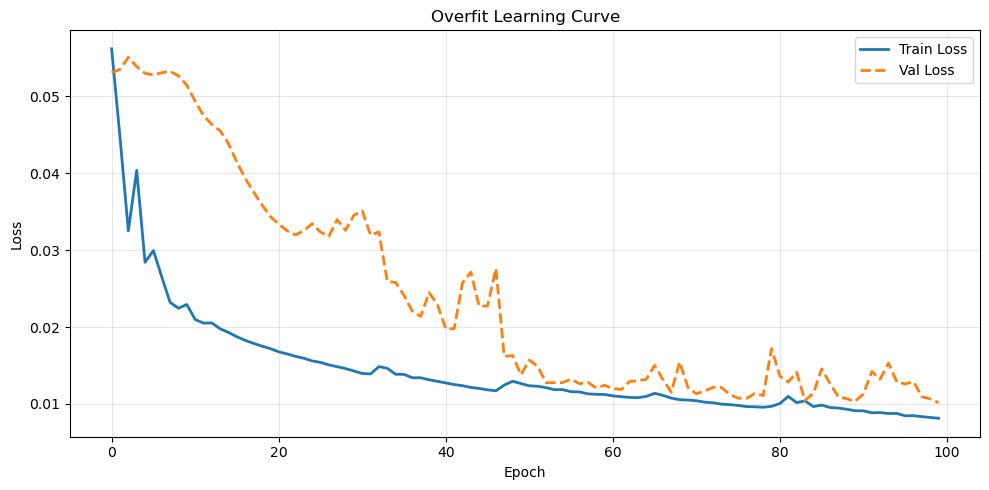

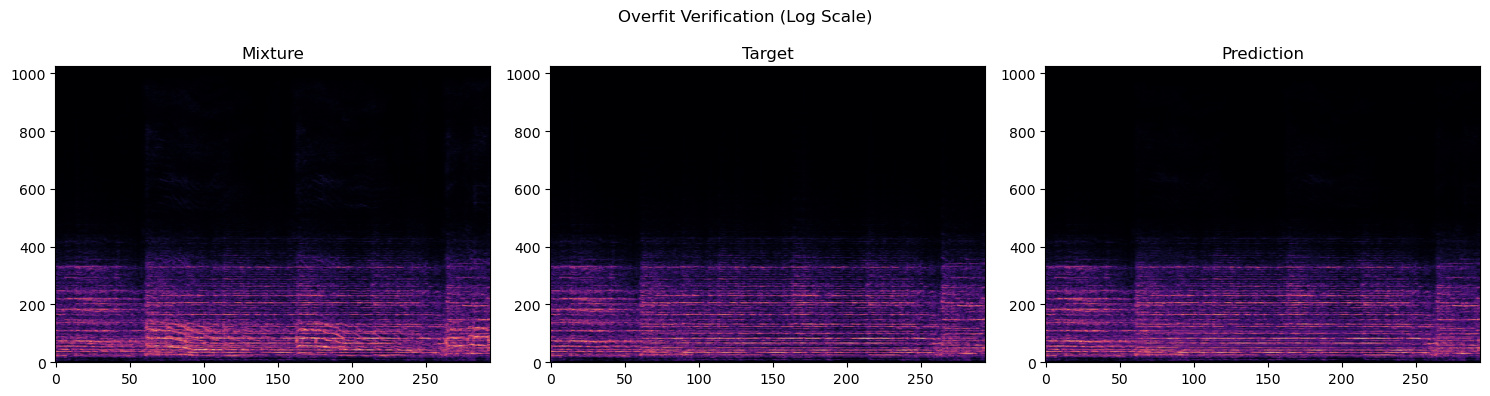

In [30]:
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import os
import torch
os.makedirs("../checkpoints", exist_ok=True)

print("Starting Overfit Test...")

# Prepare tiny dataset
s1_root = Path("../data/curriculum/stage1")
mix_files = sorted(list((s1_root / "mixture").glob("*.npy")))[:1]
tgt_files = sorted(list((s1_root / "target").glob("*.npy")))[:1]

tiny_ds = utils.StandardDataset(mix_files, tgt_files)
tiny_loader = DataLoader(tiny_ds, batch_size=1, shuffle=False)

trainer_overfit = utils.UniversalTrainer(
    model=overfit_model,
    train_loader=tiny_loader,
    val_loader=tiny_loader,
    processor=processor,
    optimizer=overfit_optimizer,
    loss_fn=overfit_loss_fn,
    device=device,
    patience=overfit_num_epochs
)

save_path = "../checkpoints/debug_overfit.pth"
history = {}

if not os.path.exists(save_path):
    print("   Training from scratch...")
    history = trainer_overfit.train(num_epochs=overfit_num_epochs, save_path=save_path)
else:
    print(f"✓ Found Checkpoint: {save_path}")
    ckpt = torch.load(save_path, map_location=device)
    overfit_model.load_state_dict(ckpt['model_state_dict'])
    history = ckpt.get('history', {})

utils.plot_loss_history(history, "Overfit Learning Curve")

batch = next(iter(tiny_loader))
mix = batch['mix'].to(device)
tgt = batch['tgt'].to(device)

overfit_model.eval()
with torch.no_grad():
    mix_log, _ = processor.to_spectrogram(mix)
    tgt_log, _ = processor.to_spectrogram(tgt)
    mix_in = mix_log.unsqueeze(1)
    mask = overfit_model(mix_in)
    if mask.shape != mix_in.shape:
        mask = mask[:, :, :mix_in.shape[2], :mix_in.shape[3]]
    est_linear = mask * torch.expm1(mix_in)
    est_log = torch.log1p(est_linear)

utils.visualize_results(mix_log[0], tgt_log[0], est_log[0].squeeze(), title="Overfit Verification (Log Scale)")

# Listen to mixture, target, and predicted audio

In [31]:
from models.utils import play_audio

sr = 22050

mix_wav = processor.to_waveform(mix_log[0].cpu(), torch.zeros_like(mix_log[0]))
tgt_wav = processor.to_waveform(tgt_log[0].cpu(), torch.zeros_like(tgt_log[0]))
est_wav = processor.to_waveform(est_log[0].cpu(), torch.zeros_like(est_log[0]))

play_audio(mix_wav, sr=sr, title="Mixture Audio (Overfit)")
play_audio(tgt_wav, sr=sr, title="Target Audio (Overfit)")
play_audio(est_wav, sr=sr, title="Predicted Audio (Overfit)")

Mixture Audio (Overfit):


Target Audio (Overfit):


Predicted Audio (Overfit):


### 5.b Full Training

- Train the model on the full training dataset as intended.


Starting Full Training Pipeline...

--- Stage 1: Vocals + Other -> Other ---
✓ Found Checkpoint: ../checkpoints/full_stage1.pth


C:\Users\MARKUS-VIDER\AppData\Local\Temp\ipykernel_7348\4283650209.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path_s1, map_location=device)


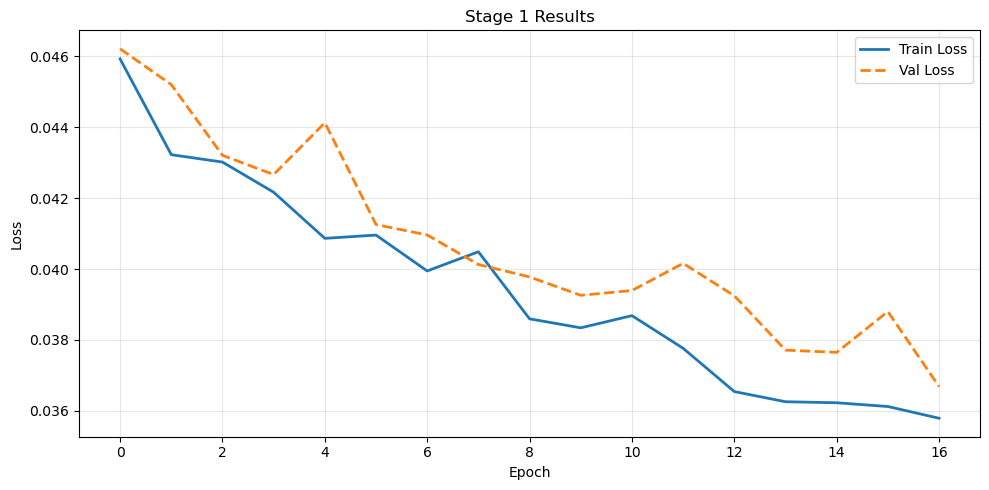


Visualizing Stage 1 Spectrograms...


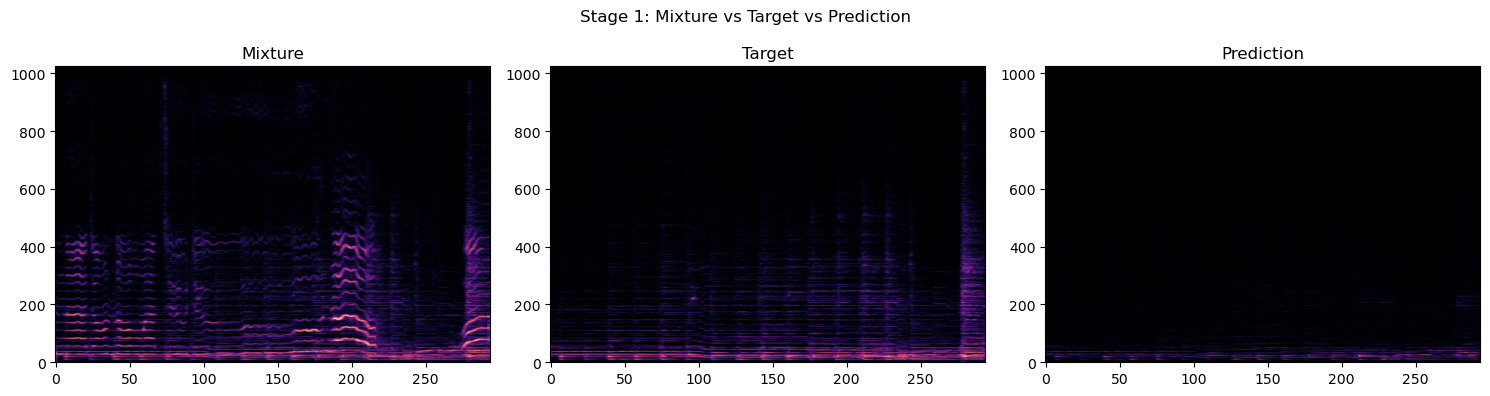


--- Stage 2: Full Mix -> Other ---
✓ Optimizer LR reduced to 1e-05
✓ Found Checkpoint: ../checkpoints/full_stage2.pth


C:\Users\MARKUS-VIDER\AppData\Local\Temp\ipykernel_7348\4283650209.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path_s2, map_location=device)


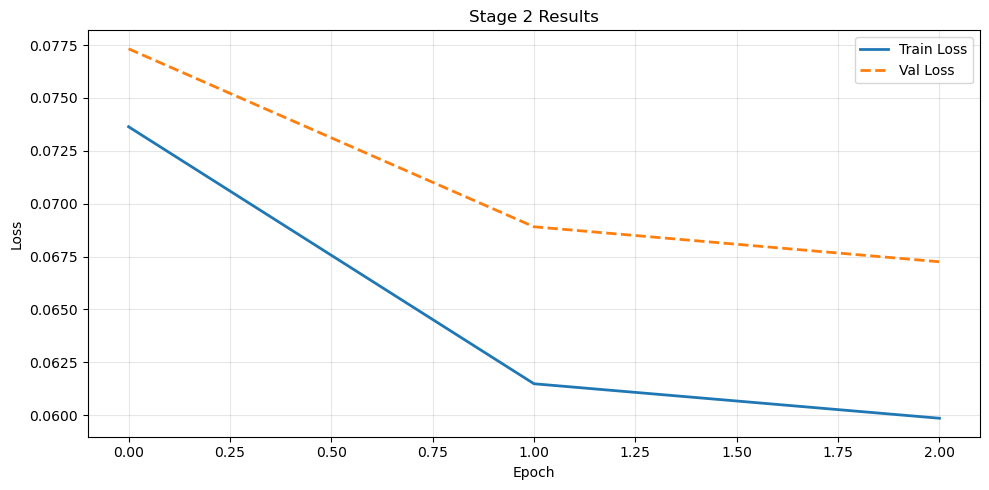


Visualizing Stage 2 Spectrograms...


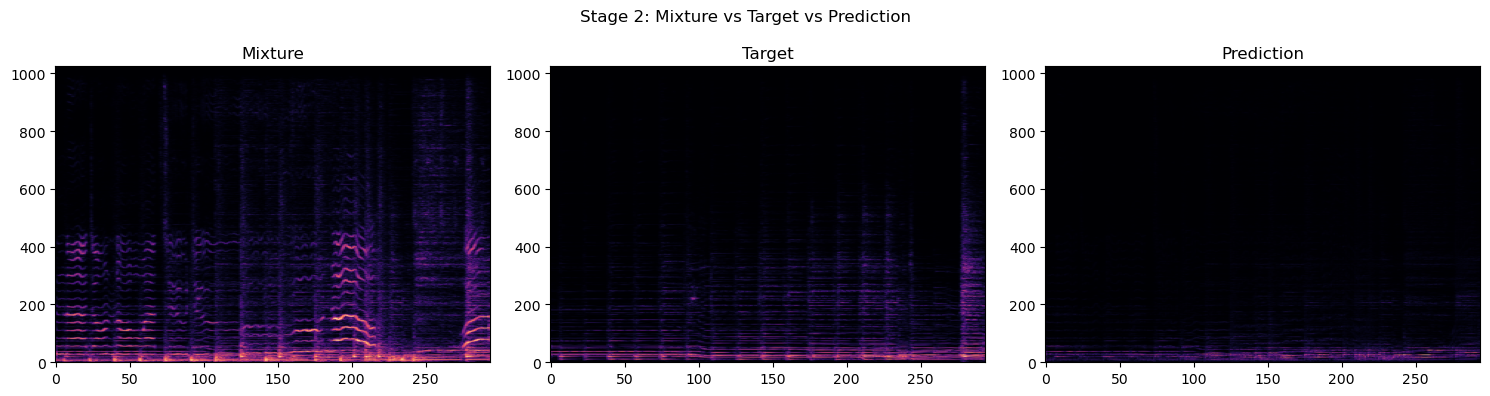

In [32]:
print("Starting Full Training Pipeline...")

# Stage 1
print("\n--- Stage 1: Vocals + Other -> Other ---")

s1_root = Path("../data/curriculum/stage1")
s1_mix = sorted(list((s1_root / "mixture").glob("*.npy")))
s1_tgt = sorted(list((s1_root / "target").glob("*.npy")))

split_s1 = int(len(s1_mix) * 0.8)
train_ds1 = utils.StandardDataset(s1_mix[:split_s1], s1_tgt[:split_s1])
val_ds1 = utils.StandardDataset(s1_mix[split_s1:], s1_tgt[split_s1:])

train_loader1 = DataLoader(train_ds1, batch_size=batch_size, shuffle=True)
val_loader1 = DataLoader(val_ds1, batch_size=batch_size, shuffle=False)

trainer_s1 = utils.UniversalTrainer(
    model=model,
    train_loader=train_loader1,
    val_loader=val_loader1,
    processor=processor,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    patience=patience
)

path_s1 = "../checkpoints/full_stage1.pth"
hist_s1 = {}

if not os.path.exists(path_s1):
    hist_s1 = trainer_s1.train(num_epochs=2, save_path=path_s1)
else:
    print(f"✓ Found Checkpoint: {path_s1}")
    ckpt = torch.load(path_s1, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    hist_s1 = ckpt.get('history', {})

utils.plot_loss_history(hist_s1, "Stage 1 Results")

print("\nVisualizing Stage 1 Spectrograms...")
sample_batch = next(iter(val_loader1))
mix = sample_batch['mix'].to(device)
tgt = sample_batch['tgt'].to(device)
model.eval()
with torch.no_grad():
    mix_mag, _ = processor.to_spectrogram(mix)
    tgt_mag, _ = processor.to_spectrogram(tgt)
    mix_in = mix_mag.unsqueeze(1)
    mask = model(mix_in)
    if mask.shape != mix_in.shape:
        mask = mask[:, :, :mix_in.shape[2], :mix_in.shape[3]]
    est_mag = mask * torch.expm1(mix_in)
utils.visualize_results(mix_mag[0], tgt_mag[0], est_mag[0].squeeze(), title="Stage 1: Mixture vs Target vs Prediction")

# Stage 2
print("\n--- Stage 2: Full Mix -> Other ---")

s2_root = Path("../data/curriculum/stage2")
s2_mix = sorted(list((s2_root / "mixture").glob("*.npy")))
s2_tgt = sorted(list((s2_root / "target").glob("*.npy")))

split_s2 = int(len(s2_mix) * 0.8)
train_ds2 = utils.StandardDataset(s2_mix[:split_s2], s2_tgt[:split_s2])
val_ds2 = utils.StandardDataset(s2_mix[split_s2:], s2_tgt[split_s2:])

train_loader2 = DataLoader(train_ds2, batch_size=batch_size, shuffle=True)
val_loader2 = DataLoader(val_ds2, batch_size=batch_size, shuffle=False)

for param_group in optimizer.param_groups:
    param_group['lr'] = learning_rate * 0.1
print(f"✓ Optimizer LR reduced to {learning_rate * 0.1}")

trainer_s2 = utils.UniversalTrainer(
    model=model,
    train_loader=train_loader2,
    val_loader=val_loader2,
    processor=processor,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    patience=patience
)

path_s2 = "../checkpoints/full_stage2.pth"
hist_s2 = {}

if not os.path.exists(path_s2):
    hist_s2 = trainer_s2.train(num_epochs=2, save_path=path_s2)
else:
    print(f"✓ Found Checkpoint: {path_s2}")
    ckpt = torch.load(path_s2, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    hist_s2 = ckpt.get('history', {})

utils.plot_loss_history(hist_s2, "Stage 2 Results")

print("\nVisualizing Stage 2 Spectrograms...")
sample_batch = next(iter(val_loader2))
mix = sample_batch['mix'].to(device)
tgt = sample_batch['tgt'].to(device)
model.eval()
with torch.no_grad():
    mix_mag, _ = processor.to_spectrogram(mix)
    tgt_mag, _ = processor.to_spectrogram(tgt)
    mix_in = mix_mag.unsqueeze(1)
    mask = model(mix_in)
    if mask.shape != mix_in.shape:
        mask = mask[:, :, :mix_in.shape[2], :mix_in.shape[3]]
    est_mag = mask * torch.expm1(mix_in)
utils.visualize_results(mix_mag[0], tgt_mag[0], est_mag[0].squeeze(), title="Stage 2: Mixture vs Target vs Prediction")

## 6. Evaluation and Inference

- Run the trained model on test data

- Visualize separated sources (waveforms, spectrograms)

- Optionally, compute evaluation metrics (e.g., SDR, SIR)


C:\Users\MARKUS-VIDER\AppData\Local\Temp\ipykernel_7348\553211111.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


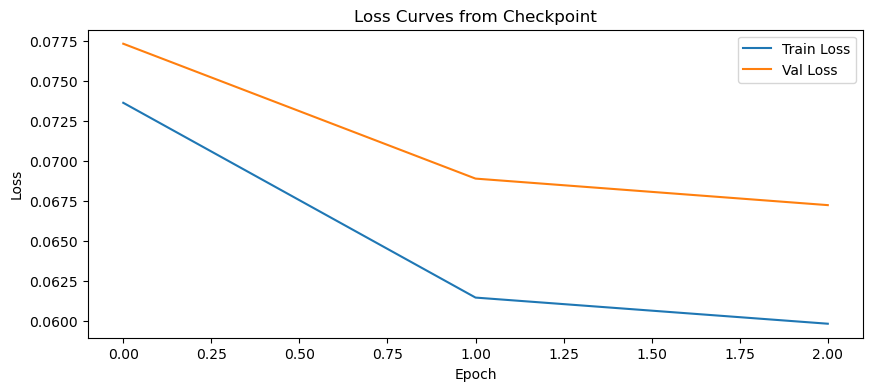

In [35]:
import torch
import matplotlib.pyplot as plt

ckpt_path = "../checkpoints/full_stage2.pth"

ckpt = torch.load(ckpt_path, map_location='cpu')
if 'history' in ckpt:
    history = ckpt['history']
    plt.figure(figsize=(10, 4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Loss Curves from Checkpoint")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
else:
    print("No loss history found in checkpoint.")

## 7. Listen to the masked songs

- listen to masked songs from the MUSDB18 dataset

- watch the spectrograms

- upload a song to model_A_input folder

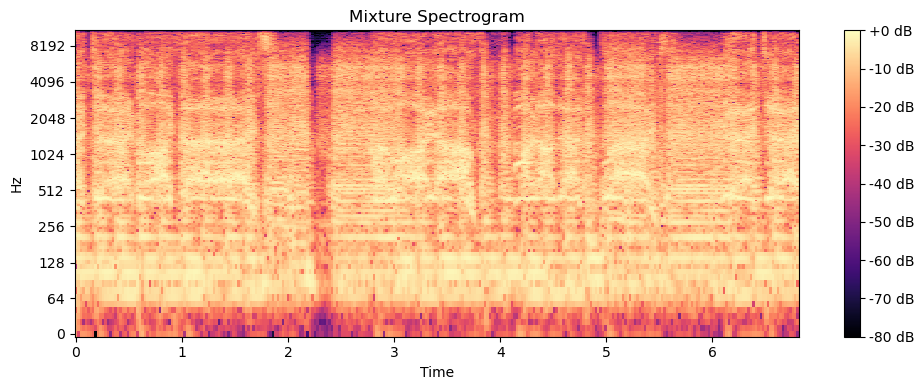

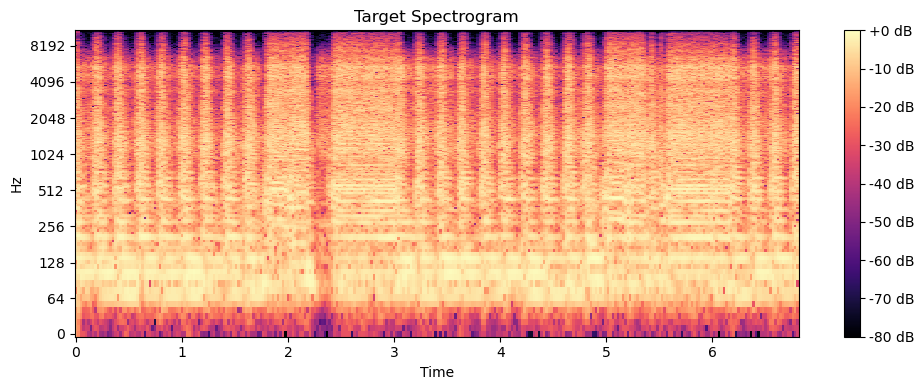

ValueError: mix_mag_in must be 4D, got shape torch.Size([1, 1, 1, 1025, 294])

In [37]:
import os
import numpy as np
import torch
from models.utils import show_spectrogram, play_audio, AudioProcessor
from models.model_A import TimeFrequencyDomainUNet
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Load a sample from MUSDB18 cache
data_root = Path("../data/curriculum")
s1_mix_path = data_root / "stage1" / "mixture"
s1_tgt_path = data_root / "stage1" / "target"
mix_files = sorted(list(s1_mix_path.glob("*.npy")))
tgt_files = sorted(list(s1_tgt_path.glob("*.npy")))
song_num = 36  # Change this to select a different sample frrom dataset musdb18

sample_idx = song_num
mix_wav = np.load(mix_files[sample_idx])
tgt_wav = np.load(tgt_files[sample_idx])
sr = 22050 # Sample rate

# Compute and show spectrograms
processor = AudioProcessor(device=device)
mix_mag, mix_phase = processor.to_spectrogram(torch.tensor(mix_wav))
tgt_mag, tgt_phase = processor.to_spectrogram(torch.tensor(tgt_wav))
show_spectrogram(mix_mag, title="Mixture Spectrogram")
show_spectrogram(tgt_mag, title="Target Spectrogram")

# Predict masked output
model.eval()
with torch.no_grad():
    mix_mag_in = mix_mag.unsqueeze(0).unsqueeze(1).to(device)  # Shape: (1, 1, H, W)
    if mix_mag_in.dim() != 4:
        raise ValueError(f"mix_mag_in must be 4D, got shape {mix_mag_in.shape}")
    mask = model(mix_mag_in)
    if mask.shape != mix_mag_in.shape:
        mask = mask[:, :, :mix_mag_in.shape[2], :mix_mag_in.shape[3]]
    est_mag = mask.squeeze(0).squeeze(0) * mix_mag.to(device)
    est_wav = processor.to_waveform(est_mag.cpu(), mix_phase.cpu())
show_spectrogram(est_mag.cpu(), title="Predicted Spectrogram")

# Play audio
play_audio(mix_wav, sr=sr, title="Mixture Audio")
play_audio(tgt_wav, sr=sr, title="Target Audio")
play_audio(est_wav, sr=sr, title="Predicted Audio")

# Optionally upload and process your own song
input_dir = Path("../model_A_input")
os.makedirs(input_dir, exist_ok=True)
user_files = sorted(list(input_dir.glob("*.wav")))
if user_files:
    user_path = user_files[0] # Take the first uploaded music file 
    user_wav, user_sr = librosa.load(user_path, sr=sr)
    user_mag, user_phase = processor.to_spectrogram(torch.tensor(user_wav))
    show_spectrogram(user_mag, title=f"User Mixture Spectrogram: {user_path.name}")
    with torch.no_grad():
        user_mag_in = user_mag.unsqueeze(0).unsqueeze(1).to(device)  # Shape: (1, 1, H, W)
        if user_mag_in.dim() != 4:
            raise ValueError(f"user_mag_in must be 4D, got shape {user_mag_in.shape}")
        user_mask = model(user_mag_in)
        if user_mask.shape != user_mag_in.shape:
            user_mask = user_mask[:, :, :user_mag_in.shape[2], :user_mag_in.shape[3]]
        user_est_mag = user_mask.squeeze(0).squeeze(0) * user_mag.to(device)
        user_est_wav = processor.to_waveform(user_est_mag.cpu(), user_phase.cpu())
    show_spectrogram(user_est_mag.cpu(), title=f"User Predicted Spectrogram: {user_path.name}")
    play_audio(user_wav, sr=sr, title=f"User Mixture Audio: {user_path.name}")
    play_audio(user_est_wav, sr=sr, title=f"User Predicted Audio: {user_path.name}")
else:
    print("No user .wav file found in model_A_input. Upload a song to try your own audio!")